In [5]:
import sys
sys.path.insert(1, '../')
import numpy as np
from data_preparation import *
from utils import *
import csv
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['KERAS_BACKEND'] = 'tensorflow'
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
import pandas as pd
from keras.layers import Input,Bidirectional,merge
from keras.layers.core import Dense, Activation, Dropout,Permute,Flatten
from keras.layers.recurrent import LSTM
from keras.models import *
from keras.layers.convolutional import Conv1D,Conv2D
from keras.layers.pooling import MaxPooling1D,AveragePooling1D
from keras.models import load_model
from attention import AttentionLayer
from attention_with_context import AttentionWithContext
from keras.layers.wrappers import TimeDistributed
from keras.utils import CustomObjectScope
from keras.callbacks import ModelCheckpoint
from keras.callbacks import Callback

Using TensorFlow backend.


In [6]:
print('loading data...')
data1 = load_csv(r'../data-freeway/10105110', 8, "freeway")
data2 = load_csv(r'../data-freeway/10105310', 8, "freeway")
data3 = load_csv(r'../data-freeway/10105510', 8, "freeway")
data4 = load_csv(r'../data-freeway/10108210', 8, "freeway")
data5 = load_csv(r'../data-freeway/10106510', 8, "freeway")
data6 = load_csv(r'../data-freeway/1095110', 8, "freeway")
data7 = load_csv(r'../data-freeway/1095510', 8, "freeway")

loading data...
['../data-freeway/10105110\\11.csv', '../data-freeway/10105110\\12.csv', '../data-freeway/10105110\\13.csv', '../data-freeway/10105110\\14.csv', '../data-freeway/10105110\\15.csv', '../data-freeway/10105110\\16.csv', '../data-freeway/10105110\\17.csv', '../data-freeway/10105110\\18.csv', '../data-freeway/10105110\\19.csv', '../data-freeway/10105110\\20.csv', '../data-freeway/10105110\\21.csv', '../data-freeway/10105110\\22.csv', '../data-freeway/10105110\\23.csv', '../data-freeway/10105110\\24.csv', '../data-freeway/10105110\\25.csv', '../data-freeway/10105110\\26.csv', '../data-freeway/10105110\\27.csv', '../data-freeway/10105110\\28.csv', '../data-freeway/10105110\\29.csv', '../data-freeway/10105110\\30.csv', '../data-freeway/10105110\\31.csv', '../data-freeway/10105110\\32.csv', '../data-freeway/10105110\\33.csv', '../data-freeway/10105110\\34.csv']
['../data-freeway/10105110\\11.csv', '../data-freeway/10105110\\12.csv', '../data-freeway/10105110\\13.csv', '../data-f

In [7]:
day = 288
week = 2016
seq_len = 15
#1=5min, 3=15min, 6=30min, 12=60min
pre_len = 12
#data 1-7
pre_sens_num = 1

#train,test
train_data, train_w, train_d, label, test_data, test_w, test_d, test_l, test_med, test_min\
	= generate_data(data1, data2, data3, data4, data5, data6, data7, seq_len, pre_len, pre_sens_num)

train_data = np.reshape(train_data,(train_data.shape[0], train_data.shape[1], train_data.shape[2], 1))
train_w = np.reshape(train_w,(train_w.shape[0], train_w.shape[1], 1))
train_d = np.reshape(train_d,(train_d.shape[0], train_d.shape[1], 1))

test_data = np.reshape(test_data,(test_data.shape[0], test_data.shape[1], test_data.shape[2], 1))
test_d = np.reshape(test_d,(test_d.shape[0], test_d.shape[1], 1))
test_w = np.reshape(test_w,(test_w.shape[0], test_w.shape[1], 1))


In [8]:
#load model
with CustomObjectScope({'AttentionLayer': AttentionLayer,'AttentionWithContext':AttentionWithContext}):
	json_file = open('../model/conv_lstm.json', 'r')
	loaded_model_json = json_file.read()
	json_file.close()
	cnn_lstm_model = model_from_json(loaded_model_json)
	cnn_lstm_model.load_weights("../model/model_0040-0.0033.h5", 'r')


NAME:  attention_with_context_1


In [9]:
# start =time.clock()
predicted = predict_point_by_point(cnn_lstm_model, [test_data,test_w,test_d])

p_real = []
l_real = []
row=2016
for i in range(row):
    p_real.append(predicted[i] * test_med + test_min)
    l_real.append(test_l[i] * test_med + test_min)
p_real = np.array(p_real)
l_real = np.array(l_real)

print ("MAE:", MAE(p_real, l_real))
print ("MAPE:", MAPE(p_real, l_real))
print ("RMSE:", RMSE(p_real, l_real))

#for i in range(0,len(p_real)):
#	print(p_real[i])

# end = time.clock()

predict_size: 2016
MAE: 12.718512163940995
MAPE: 0.1913565457839304
RMSE: 17.525774964286374


In [10]:
coeff = np.max(p_real)/np.max(predicted)
print(coeff)

309.0


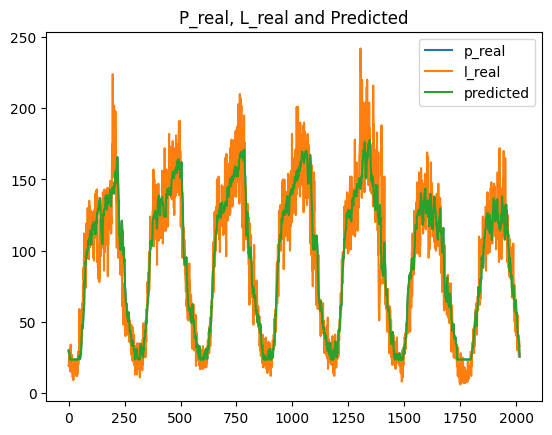

In [14]:
from ipywidgets import interact

def custom_plot(lists_to_plot, legend_list=None,plt_title=None):
    for plt_list in lists_to_plot:
        plt.plot(plt_list)
    if legend_list:
        plt.legend(legend_list)
    if plt_title:
        plt.title(plt_title)

interact(custom_plot([p_real,l_real,predicted*coeff],['p_real','l_real','predicted'],"P_real, L_real and Predicted"))

Text(0.5, 0, 'Hours')

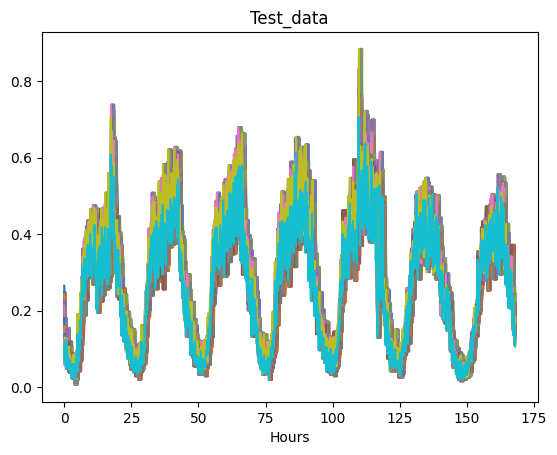

In [55]:
total_hours = 168
time = np.linspace(0, total_hours, num=row)
for i in range(0,15):
    for j in range(0,6):
        plt.plot(time,test_data[:,i,j])
plt.title("Test_data")
plt.xlabel("Hours")
#This plot shows that test_data contains 15x7 replicas of similar data

Text(0.5, 0, 'Hours')

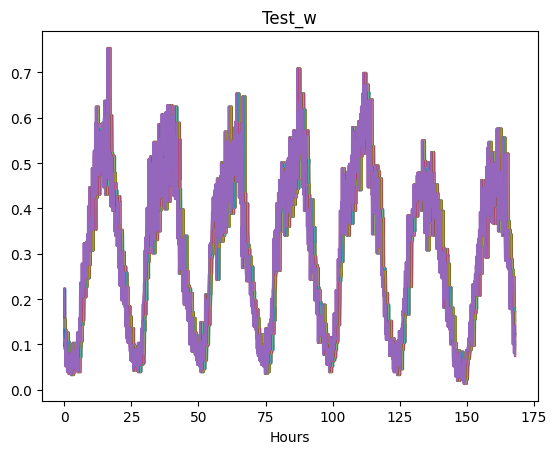

In [54]:
for i in range(0,15):
    plt.plot(time,test_w[:,i,0])
plt.title("Test_w")
plt.xlabel("Hours")
#This plot shows that test_w contains 15 replicas of similar data

Text(0.5, 0, 'Hours')

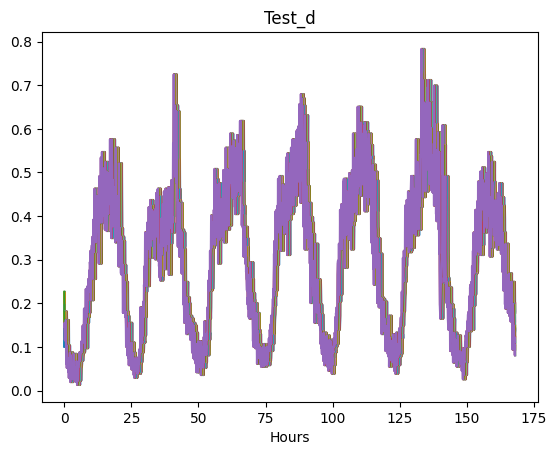

In [56]:
for i in range(0,15):
    plt.plot(time,test_d[:,i,0])
plt.title("Test_d")
plt.xlabel("Hours")
#This plot shows that test_d contains 15 replicas of similar data